## Prereqs
If you haven't already done so, run the Mnist-Policies notebook

In [13]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from joblib import Memory
from sklearn.datasets import load_svmlight_file
import tqdm
import pickle


In [4]:
mem = Memory("./mycache")

@mem.cache
def get_more_data():
    data = load_svmlight_file("xab")
    return data[0], data[1]

X, y = get_more_data()

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-nikosk.REDMOND-Desktop-projects-pycharm-mope-%3Cipython-input-bab0908ef622%3E.get_more_data...
get_more_data()
__________________________________________________get_more_data - 226.3s, 3.8min


In [8]:
from scipy.special import softmax, expit

class behavior_policy(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.w = npz['wlin']
        k = self.w.shape[1]
        self.u = np.ones(k)/k
        self.m = 0.9
        
    def __call__(self, x):
        t = self.m*softmax((x @ self.v) @ self.w, axis=-1)+(1-self.m)*self.u
        t /= t.sum(axis=-1, keepdims=1)
        return np.squeeze(t)
    
class eval_policy(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.f = npz['omega']
            self.b = npz['b']
            self.z = npz['z']
            self.w = npz['w']
        
    def __call__(self, x):
        rff = ((x/255.) @ self.v) @ self.f + self.b
        np.cos(rff, out=rff)
        rff *= self.z
        t = softmax(rff @ self.w, axis=-1)
        t /= t.sum(axis=-1, keepdims=1)
        return np.squeeze(t)
    
class reward_predictor(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.f = npz['omega']
            self.b = npz['b']
            self.z = npz['z']
            self.q = npz['q']
        
    def __call__(self, x):
        rff = ((x/255.) @ self.v) @ self.f + self.b
        np.cos(rff, out=rff)
        rff *= self.z
        t = expit(rff @ self.q)
        return np.squeeze(t)

h = behavior_policy('mnist_models.npz')
pi = eval_policy('mnist_models.npz')
q = reward_predictor('mnist_models.npz')

In [9]:
wr = []
for xi,yi in tqdm.tqdm(zip(X,y),total=y.size, ncols=80):
    hxi = h(xi)
    ai = np.random.choice(10,p=hxi)
    ri = 1 if ai == yi else 0
    pxi = pi(xi)
    qxi = q(xi)
    wi = pxi[ai]/hxi[ai]
    cv = wi*qxi[ai]-np.dot(pxi,qxi)
    wr.append((wi,ri,cv))

100%|████████████████████████████████| 1000000/1000000 [38:48<00:00, 429.53it/s]


In [14]:
wrc=np.array(wr)
with open('wrc.pkl','wb') as pkl:
    pickle.dump(wrc, pkl)

In [15]:
chunk = 1000
reward_pi = 0
reward_h = 0
iy = y.astype(np.int32)

for i in tqdm.trange(0,1000000,chunk):
    probs = pi(X[i:i+chunk])
    reward_pi += np.sum(probs[range(chunk),iy[i:i+chunk]])
    probs = h(X[i:i+chunk])
    reward_h += np.sum(probs[range(chunk),iy[i:i+chunk]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.72it/s]


In [16]:
print('pi on-policy reward:',reward_pi/y.size)
print('h  on-policy reward:',reward_h/y.size)

pi on-policy reward: 0.9384872653849122
h  on-policy reward: 0.7660206532305163


In [17]:
import opebetrp

def bet_3d(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_3d(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

def bet_rp(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_rp(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

def bet_double_rp(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_rp_double_hedge(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

In [18]:
import opebet

def bet_2d(data, wmin, wmax, alpha):
    lb, ub = opebet.wealth_lb_2d(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

In [19]:
wr0 = np.copy(wrc[:,0:2])
flb = 0
fub = 0
N = 5
for i in range(N):
    lb, ub = bet_2d(wr0[10000*i:10000*(i+1)], 0, 100, 0.001)
    print(ub[-1])
    flb = flb + lb
    fub = fub + ub
lb = flb/N
ub = fub/N

0.96996996996997
0.9669669669669669
0.974974974974975
0.970970970970971
0.968968968968969


In [21]:
flb = 0
fub = 0
for i in range(N):
    lbrp, ubrp = bet_3d(wrc[10000*i:10000*(i+1)], 0, 100, 0.001)
    flb = flb + lbrp
    fub = fub + ubrp
lbrp = flb/N
ubrp = fub/N

100%|█████████████████████████████████████| 10000/10000 [03:57<00:00, 42.17it/s]


In [23]:
flb = 0
fub = 0
for i in range(N):
    lbdouble, ubdouble = bet_double_rp(wrc[10000*i:10000*(i+1)], 0, 100, 0.001)
    flb = flb + lbdouble
    fub = fub + ubdouble
lbdouble = flb/N
ubdouble = fub/N

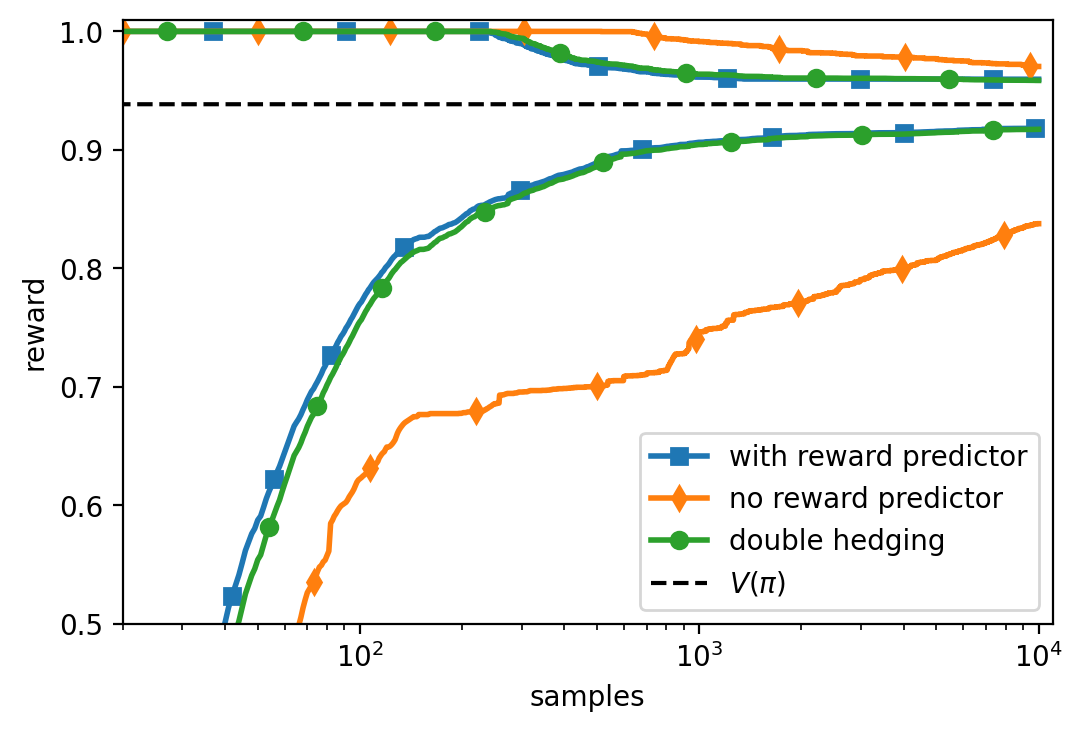

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap    
fig, ax = plt.subplots(dpi=200)
colors = get_cmap("tab10").colors 
#ax.set_prop_cycle(color=colors)
t = 1+np.arange(len(lb))
trp = 1+np.arange(len(lbrp))
tdouble = 1+np.arange(len(lbdouble))

d1 = dict(linestyle='-', marker='s', markevery=(0.00,0.12), color=colors[0], linewidth=2.0)
d2 = dict(linestyle='-', marker='d', markevery=(0.04,0.12), color=colors[1], linewidth=2.0)
d3 = dict(linestyle='-', marker='o', markevery=(0.08,0.12), color=colors[2], linewidth=2.0)
ax.plot(trp,lbrp,**d1, label='with reward predictor')
ax.plot(trp,ubrp,**d1)
ax.plot(t,lb,**d2, label='no reward predictor')
ax.plot(t,ub,**d2)
ax.plot(tdouble,lbdouble,**d3, label='double hedging')
ax.plot(tdouble,ubdouble,**d3)
truth = reward_pi/y.size*np.ones_like(lb)
ax.plot(t,truth,'k--', label='$V(\pi)$')
ax.set(xscale='log',xlim=[20,11000], ylim=[0.5,1.01], xlabel='samples', ylabel='reward')
ax.legend(loc='lower right')
fig.savefig('predictor.pdf', bbox_inches='tight', pad_inches=0)